In [30]:
import Pkg; Pkg.activate(".")
using Clapeyron
includet("./saftvrmienn.jl")
# These are functions we're going to overload for SAFTVRMieNN
import Clapeyron: a_res, saturation_pressure, pressure

using Flux
using Plots, Statistics
using ForwardDiff, DiffResults

using Zygote, ChainRulesCore
using ImplicitDifferentiation

using CSV, DataFrames
using MLUtils
using RDKitMinimalLib
using JLD2

# Multithreaded loss
using Zygote: bufferfrom
using Base.Threads: @spawn
using Plots

  Activating project at `~/SAFT_ML`


In [2]:
X = [16.04, 1.0, 3.737, 6.0, 12.504, 152.58]
V = volume_NN(X, 1e7, 100.0)
∂V∂X = Zygote.gradient(X -> volume_NN(X, 1e7, 100.0), X)

([-0.0, 2.260005096581295e-5, 2.1863843008154135e-5, 1.46022174535494e-6, 1.6493904176981177e-7, -6.011351535625539e-8],)

In [3]:
X = [16.04, 1.0, 3.737, 6.0, 12.504, 152.58]
f_V(X) = volume_NN(X, 1e7, 100.0)[1]
dX = [0.0, 0.0, 0.0, 0.0, 0.0, 1e-6]
f_∂V∂X(X) = (f_V(X .+ dX) - f_V(X .- dX))/(2dX)
f_∂V∂X(X)

1×6 transpose(::Vector{Float64}) with eltype Float64:
 -0.0  -0.0  -0.0  -0.0  -0.0  -5.78614e-8

In [19]:
# Generate training set for liquid density and saturation pressure
function create_data(; batch_size=16, n_points=25)
    # Create training & validation data
    df = CSV.read("./pcpsaft_params/SI_pcp-saft_parameters.csv", DataFrame, header=1)
    filter!(row -> occursin("Alkane", row.family), df)
    df = first(df, 1) #* Take only first molecule in dataframe
    @show df.common_name
    mol_data = zip(df.common_name, df.isomeric_smiles, df.molarweight)
    println("Generating data for $(length(mol_data)) molecules...")

    function make_fingerprint(s::String)::Vector{Float64}
        mol = get_mol(s)
        @assert !isnothing(mol)

        fp = []
        # for (nbits, rad) in [(256, 256), (1, 3)]
        #* Approximately ECFP4 fingerprint
        nbits = 256
        rad = 4

        fp_details = Dict{String,Any}("nBits" => nbits, "radius" => rad)
        fp_str = get_morgan_fp(mol, fp_details)
        append!(fp, [parse(Float64, string(c)) for c in fp_str])
        # end

        desc = get_descriptors(mol)
        relevant_keys = [
            "CrippenClogP",
            "NumHeavyAtoms",
            "amw",
            "FractionCSP3",
        ]
        relevant_desc = [desc[k] for k in relevant_keys]
        append!(fp, last.(relevant_desc))

        return fp
    end

    T = Float64
    # X_data = Vector{Tuple{Vector{T},T,T,T}}([])
    X_data = Vector{Tuple{Vector{T},T,T,T}}([])
    Y_data = Vector{Vector{T}}()

    # n = 0
    for (name, smiles, Mw) in mol_data
        # if n < 20
        try
            # saft_model = PPCSAFT([name])
            saft_model = SAFTVRMie([name])
            Tc, pc, Vc = crit_pure(saft_model)

            # fp = make_fingerprint(smiles)
            fp = [1.0]
            # append!(fp, Mw)

            T_range = range(0.5 * Tc, 0.975 * Tc, n_points)
            for T in T_range
                (p_sat, Vₗ_sat, Vᵥ_sat) = saturation_pressure(saft_model, T)

                p = p_sat * 5.0

                Vₗ = volume(saft_model, p, T; phase=:liquid)
                push!(X_data, (fp, p, T, Mw))
                push!(Y_data, [Vₗ, p_sat])
            end
            # n += 1
        catch e
            println("Fingerprint generation failed for $name, $e")
        end
        # else
        # break
        # end
    end

    #* Remove columns from fingerprints
    # Identify zero & one columns
    # num_cols = length(X_data[1][1])
    # zero_cols = trues(num_cols)
    # for (vec, _, _) in X_data
    #     zero_cols .&= (vec .== 0)
    # end
    # keep_cols = .!zero_cols # Create a Mask
    # X_data = [(vec[keep_cols], vals...) for (vec, vals...) in X_data] # Apply Mask

    # num_cols = length(X_data[1][1])
    # one_cols = trues(num_cols)
    # for (vec, _, _) in X_data
    #     one_cols .&= (vec .== 1)
    # end
    # keep_cols = .!one_cols # Create a Mask
    # X_data = [(vec[keep_cols], vals...) for (vec, vals...) in X_data] # Apply Mask

    train_data, test_data = splitobs((X_data, Y_data), at=1.0, shuffle=false)

    train_loader = DataLoader(train_data, batchsize=batch_size, shuffle=false)
    test_loader = DataLoader(test_data, batchsize=batch_size, shuffle=false)
    println("n_batches = $(length(train_loader)), batch_size = $batch_size")
    flush(stdout)
    return train_loader, test_loader
end


function create_ff_model(nfeatures)
    # Base NN architecture from "Fitting Error vs Parameter Performance"
    nout = 4
    model = Chain(
        Dense(nfeatures, nout, x -> x; bias=false, init=zeros32),
    )
    # model = Chain(
    #     Dense(nfeatures, nout * 8, relu),
    #     Dense(nout * 8, nout * 4, relu),
    #     Dense(nout * 4, nout * 2, relu),
    #     Dense(nout * 2, nout, relu),
    #     # Dense(16, nout, relu),
    #     # Dense(16, nout, x -> x),
    #     # Dense(1024, 512, relu),
    #     # Dense(512, 256, relu),
    #     # Dense(32, 32, relu),
    #     # Dense(32, 32, relu),
    #     # Dense(32, nout, relu),
    # )
    # model(x) = m, σ, λ_a, λ_r, ϵ

    # return nn_model, unbounded_model
    return model
end

function get_idx_from_iterator(iterator, idx)
    data_iterator = iterate(iterator)
    for _ in 1:idx-1
        data_iterator = iterate(iterator, data_iterator[2])
    end
    return data_iterator[1]
end


# function SAFT_head(model, X; b=[3.0, 3.5, 7.0, 12.5, 250.0], c=10.0)
# function SAFT_head(model, X; b=[2.0, 4.0], c=[1.0, 1.0])
function SAFT_head(model, X; b=[2.5, 3.5, 12.0, 250.0], c=Float64[1, 1, 10, 100])
    fp, p, T, Mw = X

    # m = 1.8514
    # σ = 4.0887
    λ_a = 6.0
    # λ_r = 13.65
    # ϵ = 273.64
    # fp, p, T, Mw = X
    pred_params = model(fp)

    # Add bias and scale
    biased_params = @. pred_params * c + b

    saft_input = vcat(Mw, biased_params[1:2], [λ_a], biased_params[3:4])

    # saft_input = vcat(Mw, biased_params[1:2], [λ_a, λ_r], ϵ)
    Vₗ = volume_NN(saft_input, p, T)

    ŷ_1 = !isnan(Vₗ) ? Vₗ : 1e3

    Tc = ignore_derivatives() do
        critical_temperature_NN(saft_input)
    end
    # todo include saturation volumes in loss
    if T < Tc
        sat_p = saturation_pressure_NN(saft_input, T)
        if !isnan(sat_p)
            ŷ_2 = sat_p
        else
            # println("sat_p is NaN at T = $T, saft_input = $saft_input")
            ŷ_2 = nothing
        end
    else
        ŷ_2 = nothing
    end

    return [ŷ_1, ŷ_2]
end

function eval_loss(X_batch, y_batch, metric, model)
    batch_loss = 0.0
    n = 0
    for (X, y_vec) in zip(X_batch, y_batch)
        # y = y_vec[1]
        ŷ_vec = SAFT_head(model, X)

        for (ŷ, y) in zip(ŷ_vec, y_vec)
            if !isnothing(ŷ)
                batch_loss += metric(y, ŷ)
                n += 1
            end
        end

    end
    if n > 0
        batch_loss /= n
    end
    # penalize batch_loss depending on how many failed
    # batch_loss += length(y_batch) - n

    return batch_loss
end

function eval_loss_par(X_batch, y_batch, metric, model, n_chunks)
    n = length(X_batch)
    chunk_size = n ÷ n_chunks

    p = bufferfrom(zeros(n_chunks))

    # Creating views for each chunk
    X_chunks = vcat([view(X_batch, (i-1)*chunk_size+1:i*chunk_size) for i in 1:n_chunks-1], [view(X_batch, (n_chunks-1)*chunk_size+1:n)])
    y_chunks = vcat([view(y_batch, (i-1)*chunk_size+1:i*chunk_size) for i in 1:n_chunks-1], [view(y_batch, (n_chunks-1)*chunk_size+1:n)])

    @sync begin
        for i = 1:n_chunks
            @spawn begin
                p[i] = eval_loss(X_chunks[i], y_chunks[i], metric, model)
            end
        end
    end
    return sum(p) / n_chunks # average partial losses
end

function percent_error(y, ŷ)
    return 100 * abs(y - ŷ) / y
end

function mse(y, ŷ)
    return ((y - ŷ) / y)^2
end

function finite_diff_grads(model, x, y; ϵ=1e-8)
    grads = []
    for p in Flux.params(model)
        push!(grads, zeros(size(p)))
    end

    for (i, p) in enumerate(Flux.params(model))
        for j in eachindex(p)
            tmp = p[j]
            p[j] = tmp + ϵ
            J1 = eval_loss(x, y, mse, model)
            p[j] = tmp - ϵ
            J2 = eval_loss(x, y, mse, model)
            p[j] = tmp
            grads[i][j] = (J1 - J2) / (2 * ϵ)
        end
    end
    return grads
end

function train_model!(model, train_loader, test_loader; epochs=10)
    optim = Flux.setup(Flux.Adam(0.001), model) # 1e-3 usually safe starting LR
    # optim = Flux.setup(Descent(0.001), model)

    println("training on $(Threads.nthreads()) threads")
    flush(stdout)
    
    for epoch in 1:epochs
        batch_loss = 0.0
        for (X_batch, y_batch) in train_loader

            loss, grads = Flux.withgradient(model) do m
                # loss = eval_loss_par(X_batch, y_batch, percent_error, m, Threads.nthreads())
                loss = eval_loss(X_batch, y_batch, mse, m)
                loss
            end
            batch_loss += loss
            @assert !isnan(loss)

            # grads_fd = finite_diff_grads(model, X_batch, y_batch)
            # @show grads[1]
            # @show grads_fd      # Show FD gradients

            Flux.update!(optim, model, grads[1])
        end
        batch_loss /= length(train_loader)
        epoch % 25 == 0 && println("epoch $epoch: batch_loss = $batch_loss")
        flush(stdout)
    end
end

function main(; epochs=15)
    train_loader, test_loader = create_data(n_points=21, batch_size=7) # Should make 5 batches / epoch. 256 / 8 gives 32 evaluations per thread
    @show n_features = length(first(train_loader)[1][1][1])

    model = create_ff_model(n_features)
    @show model.layers[1].weight, model([1.0])
    train_model!(model, train_loader, test_loader; epochs=epochs)
    return model
end

main (generic function with 1 method)

In [46]:
m = main(;epochs=10000)

df.common_name = ["n-butane"]
Generating data for 1 molecules...
n_batches = 3, batch_size = 7


n_features = length((((first(train_loader))[1])[1])[1]) = 1
((model.layers[1]).weight, model([1.0])) = (Float32[0.0; 0.0; 0.0; 0.0;;], Float32[0.0, 0.0, 0.0, 0.0])
training on 1 threads


epoch 25: batch_loss = 0.06333866275696769


epoch 50: batch_loss = 0.02630785749757164


epoch 75: batch_loss = 0.016567566385412753


epoch 100: batch_loss = 0.010465463842295568


epoch 125: batch_loss = 0.00683012599787994


epoch 150: batch_loss = 0.0048472266955072


epoch 175: batch_loss = 0.00389174959400467


epoch 200: batch_loss = 0.003512048926830051


epoch 225: batch_loss = 0.003413012618260705


epoch 250: batch_loss = 0.003422813521111424


epoch 275: batch_loss = 0.0034534771612829284


epoch 300: batch_loss = 0.00346692375334042


epoch 325: batch_loss = 0.0034513570882697664


epoch 350: batch_loss = 0.003407053043918066


epoch 375: batch_loss = 0.0033388702102891796


epoch 400: batch_loss = 0.0032526170096456655


epoch 425: batch_loss = 0.0031536175999803983


epoch 450: batch_loss = 0.0030461865493433874


epoch 475: batch_loss = 0.002933657195602863


epoch 500: batch_loss = 0.002818481728237439


epoch 525: batch_loss = 0.0027024647438456135


epoch 550: batch_loss = 0.002586879062283383


epoch 575: batch_loss = 0.0024726230114161733


epoch 600: batch_loss = 0.002360331021966561


epoch 625: batch_loss = 0.002250445200162085


epoch 650: batch_loss = 0.002143263378621259


epoch 675: batch_loss = 0.002038985638035861


epoch 700: batch_loss = 0.0019377553159395733


epoch 725: batch_loss = 0.00183965030373377


epoch 750: batch_loss = 0.0017447301753315166


epoch 775: batch_loss = 0.0016530151273919848


epoch 800: batch_loss = 0.0015645144603339551


epoch 825: batch_loss = 0.001479221613838155


epoch 850: batch_loss = 0.0013971189436543907


epoch 875: batch_loss = 0.001318182166863544


epoch 900: batch_loss = 0.0012423771730913772


epoch 925: batch_loss = 0.0011696611125040504


epoch 950: batch_loss = 0.001099996765626398


epoch 975: batch_loss = 0.001033335273051453


epoch 1000: batch_loss = 0.0009696234147969765


epoch 1025: batch_loss = 0.0009088097861970195


epoch 1050: batch_loss = 0.000850835663876635


epoch 1075: batch_loss = 0.0007956418831857314


epoch 1100: batch_loss = 0.0007431672419597055


epoch 1125: batch_loss = 0.0006933467813064889


epoch 1150: batch_loss = 0.0006461165367770932


epoch 1175: batch_loss = 0.0006014057424873266


epoch 1200: batch_loss = 0.0005591501977836153


epoch 1225: batch_loss = 0.0005192731248496138


epoch 1250: batch_loss = 0.0004817058410290476


epoch 1275: batch_loss = 0.00044637136694309926


epoch 1300: batch_loss = 0.0004132005451650252


epoch 1325: batch_loss = 0.00038211426130712505


epoch 1350: batch_loss = 0.00035304065125421467


epoch 1375: batch_loss = 0.00032589969327904283


epoch 1400: batch_loss = 0.0003006184170424706


epoch 1425: batch_loss = 0.00027711414195383347


epoch 1450: batch_loss = 0.00025531542199857827


epoch 1475: batch_loss = 0.00023514029924264399


epoch 1500: batch_loss = 0.00021651063616202556


epoch 1525: batch_loss = 0.00019935389303790728


epoch 1550: batch_loss = 0.00018359210961603508


epoch 1575: batch_loss = 0.00016914837695886946


epoch 1600: batch_loss = 0.0001559463792739864


epoch 1625: batch_loss = 0.00014391345551510238


epoch 1650: batch_loss = 0.00013297820757497092


epoch 1675: batch_loss = 0.00012306602749308576


epoch 1700: batch_loss = 0.00011410837689911377


epoch 1725: batch_loss = 0.0001060367575118987


epoch 1750: batch_loss = 9.878635002433664e-5


epoch 1775: batch_loss = 9.229135915454908e-5


epoch 1800: batch_loss = 8.649223784004559e-5


epoch 1825: batch_loss = 8.132798440560387e-5


epoch 1850: batch_loss = 7.674369223598387e-5


epoch 1875: batch_loss = 7.268578861888086e-5


epoch 1900: batch_loss = 6.910373220965762e-5


epoch 1925: batch_loss = 6.595068312791376e-5


epoch 1950: batch_loss = 6.318169683204724e-5


epoch 1975: batch_loss = 6.07566246777382e-5


epoch 2000: batch_loss = 5.8636205445600696e-5


epoch 2025: batch_loss = 5.678613187270272e-5


epoch 2050: batch_loss = 5.517519546935327e-5


epoch 2075: batch_loss = 5.377431868504406e-5


epoch 2100: batch_loss = 5.255734739352579e-5


epoch 2125: batch_loss = 5.150046564691524e-5


epoch 2150: batch_loss = 5.05837643499428e-5


epoch 2175: batch_loss = 4.978824733721868e-5


epoch 2200: batch_loss = 4.909862995584503e-5


epoch 2225: batch_loss = 4.8498273402968026e-5


epoch 2250: batch_loss = 4.79761283105448e-5


epoch 2275: batch_loss = 4.7521035713331206e-5


epoch 2300: batch_loss = 4.712325925538464e-5


epoch 2325: batch_loss = 4.677420284777509e-5


epoch 2350: batch_loss = 4.6465965198217375e-5


epoch 2375: batch_loss = 4.619267612922532e-5


epoch 2400: batch_loss = 4.594881289534375e-5


epoch 2425: batch_loss = 4.5729274233281424e-5


epoch 2450: batch_loss = 4.553006156592408e-5


epoch 2475: batch_loss = 4.534730871590337e-5


epoch 2500: batch_loss = 4.5177837038468334e-5


epoch 2525: batch_loss = 4.501873123017445e-5


epoch 2550: batch_loss = 4.4867484655204914e-5


epoch 2575: batch_loss = 4.472250737034404e-5


epoch 2600: batch_loss = 4.458198193842005e-5


epoch 2625: batch_loss = 4.4444330056113154e-5


epoch 2650: batch_loss = 4.430775096510379e-5


epoch 2675: batch_loss = 4.417209140700223e-5


epoch 2700: batch_loss = 4.4035978270091414e-5


epoch 2725: batch_loss = 4.3898682602059334e-5


epoch 2750: batch_loss = 4.376007073451536e-5


epoch 2775: batch_loss = 4.3619040569021806e-5


epoch 2800: batch_loss = 4.347573685646209e-5


epoch 2825: batch_loss = 4.332982011541354e-5


epoch 2850: batch_loss = 4.3181135967866705e-5


epoch 2875: batch_loss = 4.302953557985985e-5


epoch 2900: batch_loss = 4.2874746656446133e-5


epoch 2925: batch_loss = 4.2716675964286345e-5


epoch 2950: batch_loss = 4.25558854965388e-5


epoch 2975: batch_loss = 4.2391534664825164e-5


epoch 3000: batch_loss = 4.222418789926098e-5


epoch 3025: batch_loss = 4.205420575880648e-5


epoch 3050: batch_loss = 4.188090242923939e-5


epoch 3075: batch_loss = 4.170495223293567e-5


epoch 3100: batch_loss = 4.152606792180997e-5


epoch 3125: batch_loss = 4.1344580451694836e-5


epoch 3150: batch_loss = 4.116025335549052e-5


epoch 3175: batch_loss = 4.09735962954877e-5


epoch 3200: batch_loss = 4.078456090657006e-5


epoch 3225: batch_loss = 4.059348660747141e-5


epoch 3250: batch_loss = 4.039981594527418e-5


epoch 3275: batch_loss = 4.02045259803537e-5


epoch 3300: batch_loss = 4.000733580841092e-5


epoch 3325: batch_loss = 3.980821314566042e-5


epoch 3350: batch_loss = 3.960746866740756e-5


epoch 3375: batch_loss = 3.9405503285270657e-5


epoch 3400: batch_loss = 3.9202094866981494e-5


epoch 3425: batch_loss = 3.899712829185702e-5


epoch 3450: batch_loss = 3.8791153922570675e-5


epoch 3475: batch_loss = 3.858388271032795e-5


epoch 3500: batch_loss = 3.8376388485350585e-5


epoch 3525: batch_loss = 3.816730228463632e-5


epoch 3550: batch_loss = 3.79581632630003e-5


epoch 3575: batch_loss = 3.774837327053015e-5


epoch 3600: batch_loss = 3.753802888873204e-5


epoch 3625: batch_loss = 3.732729409977124e-5


epoch 3650: batch_loss = 3.711607177298138e-5


epoch 3675: batch_loss = 3.690501994552775e-5


epoch 3700: batch_loss = 3.669342548662177e-5


epoch 3725: batch_loss = 3.6482156023453665e-5


epoch 3750: batch_loss = 3.627085201702133e-5


epoch 3775: batch_loss = 3.605945647520928e-5


epoch 3800: batch_loss = 3.5848476040803124e-5


epoch 3825: batch_loss = 3.563754863096351e-5


epoch 3850: batch_loss = 3.5426732655502574e-5


epoch 3875: batch_loss = 3.5216636937092034e-5


epoch 3900: batch_loss = 3.5006968909998e-5


epoch 3925: batch_loss = 3.479750642102358e-5


epoch 3950: batch_loss = 3.458861241408026e-5


epoch 3975: batch_loss = 3.438035306643496e-5


epoch 4000: batch_loss = 3.417258568130344e-5


epoch 4025: batch_loss = 3.3965359545541896e-5


epoch 4050: batch_loss = 3.375874675037038e-5


epoch 4075: batch_loss = 3.3552727685330484e-5


epoch 4100: batch_loss = 3.3347699891571495e-5


epoch 4125: batch_loss = 3.314319557626525e-5


epoch 4150: batch_loss = 3.2939381301655293e-5


epoch 4175: batch_loss = 3.2736455780673294e-5


epoch 4200: batch_loss = 3.2534332618686883e-5


epoch 4225: batch_loss = 3.2332839564681904e-5


epoch 4250: batch_loss = 3.213234954347519e-5


epoch 4275: batch_loss = 3.1932967022855806e-5


epoch 4300: batch_loss = 3.173393471507511e-5


epoch 4325: batch_loss = 3.153598457760189e-5


epoch 4350: batch_loss = 3.1338639665297887e-5


epoch 4375: batch_loss = 3.114262101348414e-5


epoch 4400: batch_loss = 3.094715184385558e-5


epoch 4425: batch_loss = 3.075283942564742e-5


epoch 4450: batch_loss = 3.055938505662883e-5


epoch 4475: batch_loss = 3.036649602891102e-5


epoch 4500: batch_loss = 3.0174759336217344e-5


epoch 4525: batch_loss = 2.9984180268717315e-5


epoch 4550: batch_loss = 2.9794335648586483e-5


epoch 4575: batch_loss = 2.9605025783175185e-5


epoch 4600: batch_loss = 2.9417206135916445e-5


epoch 4625: batch_loss = 2.9230306075633466e-5


epoch 4650: batch_loss = 2.9044027411607955e-5


epoch 4675: batch_loss = 2.8858870503772883e-5


epoch 4700: batch_loss = 2.8674541766671327e-5


epoch 4725: batch_loss = 2.8491337704981938e-5


epoch 4750: batch_loss = 2.8308892477855346e-5


epoch 4775: batch_loss = 2.812775066152394e-5


epoch 4800: batch_loss = 2.7947384364469084e-5


epoch 4825: batch_loss = 2.776788264370255e-5


epoch 4850: batch_loss = 2.75892788581876e-5


epoch 4875: batch_loss = 2.741173821690649e-5


epoch 4900: batch_loss = 2.7234917025767175e-5


epoch 4925: batch_loss = 2.7059460744598435e-5


epoch 4950: batch_loss = 2.688474483567188e-5


epoch 4975: batch_loss = 2.671099513969998e-5


epoch 5000: batch_loss = 2.653803961396252e-5


epoch 5025: batch_loss = 2.6366225544867045e-5


epoch 5050: batch_loss = 2.6195344616580422e-5


epoch 5075: batch_loss = 2.6025331764844864e-5


epoch 5100: batch_loss = 2.5856249192518326e-5


epoch 5125: batch_loss = 2.5688153031518134e-5


epoch 5150: batch_loss = 2.5520788427081722e-5


epoch 5175: batch_loss = 2.5354760587478915e-5


epoch 5200: batch_loss = 2.5189273628436853e-5


epoch 5225: batch_loss = 2.502489631742264e-5


epoch 5250: batch_loss = 2.48612224650794e-5


epoch 5275: batch_loss = 2.4698811565231847e-5


epoch 5300: batch_loss = 2.4537054913949136e-5


epoch 5325: batch_loss = 2.4376470128626392e-5


epoch 5350: batch_loss = 2.4216373844731535e-5


epoch 5375: batch_loss = 2.4057612690035862e-5


epoch 5400: batch_loss = 2.3899453831341644e-5


epoch 5425: batch_loss = 2.374229265206875e-5


epoch 5450: batch_loss = 2.3586223429575437e-5


epoch 5475: batch_loss = 2.3430637885047485e-5


epoch 5500: batch_loss = 2.3276163921857776e-5


epoch 5525: batch_loss = 2.3122504514330083e-5


epoch 5550: batch_loss = 2.2969764747666523e-5


epoch 5575: batch_loss = 2.2817983083467217e-5


epoch 5600: batch_loss = 2.2666884703095687e-5


epoch 5625: batch_loss = 2.251683405480664e-5


epoch 5650: batch_loss = 2.2367525152321485e-5


epoch 5675: batch_loss = 2.2219095392702582e-5


epoch 5700: batch_loss = 2.2071377532243097e-5


epoch 5725: batch_loss = 2.1924861334877963e-5


epoch 5750: batch_loss = 2.1778821280747373e-5


epoch 5775: batch_loss = 2.1633991339747126e-5


epoch 5800: batch_loss = 2.1489653031197772e-5


epoch 5825: batch_loss = 2.1346318027796113e-5


epoch 5850: batch_loss = 2.120373489387398e-5


epoch 5875: batch_loss = 2.1062107145723628e-5


epoch 5900: batch_loss = 2.092118072569961e-5


epoch 5925: batch_loss = 2.0781185489599137e-5


epoch 5950: batch_loss = 2.064185445485321e-5


epoch 5975: batch_loss = 2.0503543873169015e-5


epoch 6000: batch_loss = 2.0365836196323253e-5


epoch 6025: batch_loss = 2.022908086492596e-5


epoch 6050: batch_loss = 2.009297815291688e-5


epoch 6075: batch_loss = 1.9957685561587102e-5


epoch 6100: batch_loss = 1.9823440446540774e-5


epoch 6125: batch_loss = 1.968966560508541e-5


epoch 6150: batch_loss = 1.9556652908670777e-5


epoch 6175: batch_loss = 1.9424594072047488e-5


epoch 6200: batch_loss = 1.9293165586911976e-5


epoch 6225: batch_loss = 1.916264892969693e-5


epoch 6250: batch_loss = 1.9032932995192992e-5


epoch 6275: batch_loss = 1.8903837430373386e-5


epoch 6300: batch_loss = 1.8775712435234517e-5


epoch 6325: batch_loss = 1.864798746165446e-5


epoch 6350: batch_loss = 1.8521393632369136e-5


epoch 6375: batch_loss = 1.8395351261584163e-5


epoch 6400: batch_loss = 1.8270077954403928e-5


epoch 6425: batch_loss = 1.81456385986797e-5


epoch 6450: batch_loss = 1.8021654959705265e-5


epoch 6475: batch_loss = 1.789874414310326e-5


epoch 6500: batch_loss = 1.7776325749328994e-5


epoch 6525: batch_loss = 1.7654791017745704e-5


epoch 6550: batch_loss = 1.7533809697965705e-5


epoch 6575: batch_loss = 1.74137339731904e-5


epoch 6600: batch_loss = 1.7294167836678346e-5


epoch 6625: batch_loss = 1.7175638499679968e-5


epoch 6650: batch_loss = 1.7057572611272186e-5


epoch 6675: batch_loss = 1.694022250704199e-5


epoch 6700: batch_loss = 1.6823537712654698e-5


epoch 6725: batch_loss = 1.6707651859793436e-5


epoch 6750: batch_loss = 1.6592391686107942e-5


epoch 6775: batch_loss = 1.647790505465528e-5


epoch 6800: batch_loss = 1.636393974415038e-5


epoch 6825: batch_loss = 1.625081874304351e-5


epoch 6850: batch_loss = 1.613827146692953e-5


epoch 6875: batch_loss = 1.602646488249601e-5


epoch 6900: batch_loss = 1.5915267796804855e-5


epoch 6925: batch_loss = 1.5804843735297137e-5


epoch 6950: batch_loss = 1.569498721745925e-5


epoch 6975: batch_loss = 1.5585880556691857e-5


epoch 7000: batch_loss = 1.5477433181850177e-5


epoch 7025: batch_loss = 1.5369528640067286e-5


epoch 7050: batch_loss = 1.5262387042356593e-5


epoch 7075: batch_loss = 1.5155766717523497e-5


epoch 7100: batch_loss = 1.5049968175367327e-5


epoch 7125: batch_loss = 1.4944694902587956e-5


epoch 7150: batch_loss = 1.4840019765850637e-5


epoch 7175: batch_loss = 1.4736088911262576e-5


epoch 7200: batch_loss = 1.4632772560739414e-5


epoch 7225: batch_loss = 1.453008993025401e-5


epoch 7250: batch_loss = 1.4427919286159627e-5


epoch 7275: batch_loss = 1.4326309016170867e-5


epoch 7300: batch_loss = 1.4225581200353675e-5


epoch 7325: batch_loss = 1.4125307669252425e-5


epoch 7350: batch_loss = 1.4025668143868393e-5


epoch 7375: batch_loss = 1.3926702979462866e-5


epoch 7400: batch_loss = 1.3828310052397267e-5


epoch 7425: batch_loss = 1.3730315700517546e-5


epoch 7450: batch_loss = 1.3633289193786014e-5


epoch 7475: batch_loss = 1.3536552630461751e-5


epoch 7500: batch_loss = 1.3440530075865443e-5


epoch 7525: batch_loss = 1.334518453813109e-5


epoch 7550: batch_loss = 1.3250360857605379e-5


epoch 7575: batch_loss = 1.3156092604215007e-5


epoch 7600: batch_loss = 1.3062498843821805e-5


epoch 7625: batch_loss = 1.2969354359161037e-5


epoch 7650: batch_loss = 1.2876807513163021e-5


epoch 7675: batch_loss = 1.2784772818388734e-5


epoch 7700: batch_loss = 1.269339788395729e-5


epoch 7725: batch_loss = 1.2602737517771266e-5


epoch 7750: batch_loss = 1.2512369865545099e-5


epoch 7775: batch_loss = 1.2422727498764886e-5


epoch 7800: batch_loss = 1.2333688343589485e-5


epoch 7825: batch_loss = 1.2245041796909084e-5


epoch 7850: batch_loss = 1.2156993151612758e-5


epoch 7875: batch_loss = 1.2069484034547335e-5


epoch 7900: batch_loss = 1.1982459579102557e-5


epoch 7925: batch_loss = 1.1896137467315718e-5


epoch 7950: batch_loss = 1.1810290784727357e-5


epoch 7975: batch_loss = 1.1724989400427357e-5


epoch 8000: batch_loss = 1.1640252443375132e-5


epoch 8025: batch_loss = 1.1555981168579373e-5


epoch 8050: batch_loss = 1.1472185584733798e-5


epoch 8075: batch_loss = 1.1389052837374833e-5


epoch 8100: batch_loss = 1.1306460599091702e-5


epoch 8125: batch_loss = 1.122424731320613e-5


epoch 8150: batch_loss = 1.1142628010506875e-5


epoch 8175: batch_loss = 1.1061461499471633e-5


epoch 8200: batch_loss = 1.0980820710426689e-5


epoch 8225: batch_loss = 1.0900805767290516e-5


epoch 8250: batch_loss = 1.0821224999568248e-5


epoch 8275: batch_loss = 1.0742078983692333e-5


epoch 8300: batch_loss = 1.0663507812720657e-5


epoch 8325: batch_loss = 1.0585318892866486e-5


epoch 8350: batch_loss = 1.0507843982942886e-5


epoch 8375: batch_loss = 1.0430612784583999e-5


epoch 8400: batch_loss = 1.035406244558913e-5


epoch 8425: batch_loss = 1.027789964819011e-5


epoch 8450: batch_loss = 1.020235905354128e-5


epoch 8475: batch_loss = 1.0127111660275637e-5


epoch 8500: batch_loss = 1.0052498105099897e-5


epoch 8525: batch_loss = 9.978292197384742e-6


epoch 8550: batch_loss = 9.904527314930401e-6


epoch 8575: batch_loss = 9.831217628974186e-6


epoch 8600: batch_loss = 9.758401821261308e-6


epoch 8625: batch_loss = 9.68610689879584e-6


epoch 8650: batch_loss = 9.614227058737719e-6


epoch 8675: batch_loss = 9.542833867766233e-6


epoch 8700: batch_loss = 9.471935933154227e-6


epoch 8725: batch_loss = 9.40146993906731e-6


epoch 8750: batch_loss = 9.331216456153036e-6


epoch 8775: batch_loss = 9.26189156126457e-6


epoch 8800: batch_loss = 9.192669867318503e-6


epoch 8825: batch_loss = 9.1239683240502e-6


epoch 8850: batch_loss = 9.055787692556515e-6


epoch 8875: batch_loss = 8.987831701909627e-6


epoch 8900: batch_loss = 8.92057203600622e-6


epoch 8925: batch_loss = 8.85352252098166e-6


epoch 8950: batch_loss = 8.787204786261297e-6


epoch 8975: batch_loss = 8.720966615674589e-6


epoch 9000: batch_loss = 8.65571019259296e-6


epoch 9025: batch_loss = 8.59010864694487e-6


epoch 9050: batch_loss = 8.525789496590582e-6


epoch 9075: batch_loss = 8.460706604282683e-6


epoch 9100: batch_loss = 8.397235746573012e-6


epoch 9125: batch_loss = 8.33317839248622e-6


epoch 9150: batch_loss = 8.270960163045655e-6


epoch 9175: batch_loss = 8.206967235074022e-6


epoch 9200: batch_loss = 8.149395705166679e-6


epoch 9225: batch_loss = 8.066700696701342e-6


epoch 9250: batch_loss = 8.199194190186415e-6


epoch 9275: batch_loss = 8.492827266225782e-6


epoch 9300: batch_loss = 7.887885575551732e-6


epoch 9325: batch_loss = 7.8203123710549e-6


epoch 9350: batch_loss = 7.763145015637046e-6


epoch 9375: batch_loss = 7.707489943190979e-6


epoch 9400: batch_loss = 7.650971958920605e-6


epoch 9425: batch_loss = 7.59541255159346e-6


epoch 9450: batch_loss = 7.5389564035950005e-6


epoch 9475: batch_loss = 7.485642881617106e-6


epoch 9500: batch_loss = 7.4166901401659845e-6


epoch 9525: batch_loss = 7.563490069358424e-6


epoch 9550: batch_loss = 8.405045677181902e-6


epoch 9575: batch_loss = 7.224434382335438e-6


epoch 9600: batch_loss = 7.18219268407468e-6


epoch 9625: batch_loss = 7.132331864856098e-6


epoch 9650: batch_loss = 7.082550183403791e-6


epoch 9675: batch_loss = 7.032379962054032e-6


epoch 9700: batch_loss = 6.982542072070266e-6


epoch 9725: batch_loss = 6.932291615507073e-6


epoch 9750: batch_loss = 6.883336575779692e-6


epoch 9775: batch_loss = 6.821924345202737e-6


epoch 9800: batch_loss = 7.229737363323721e-6


epoch 9825: batch_loss = 6.74756005785974e-6


epoch 9850: batch_loss = 6.647866305121958e-6


epoch 9875: batch_loss = 6.600997603131916e-6


epoch 9900: batch_loss = 6.5566193525226066e-6


epoch 9925: batch_loss = 6.512710320958189e-6


epoch 9950: batch_loss = 6.4680497655247485e-6


epoch 9975: batch_loss = 6.42375488230588e-6


epoch 10000: batch_loss = 6.378850461343571e-6


Chain(
  Dense(1 => 4, #147; bias=false),      # 4 parameters
) 

In [ ]:
# Todo: code to create saturation envelopes for given envelopes

In [47]:
fieldnames(typeof(m.layers[1]))
m.layers[1].weight

4×1 Matrix{Float32}:
 -0.5202797
  0.48394737
  0.06521285
  0.03438539

In [48]:
b = [2.5, 3.5, 12, 250.0]
# b = [2.0, 4.0, 250.0]
c = Float64[1, 1, 10, 100]
# b = [2.0, 4.0]
# c = Float64[1, 1]
params = m([1.0]) .* c .+ b

4-element Vector{Float64}:
   1.9797202944755554
   3.983947366476059
  12.652128532528877
 253.43853905797005

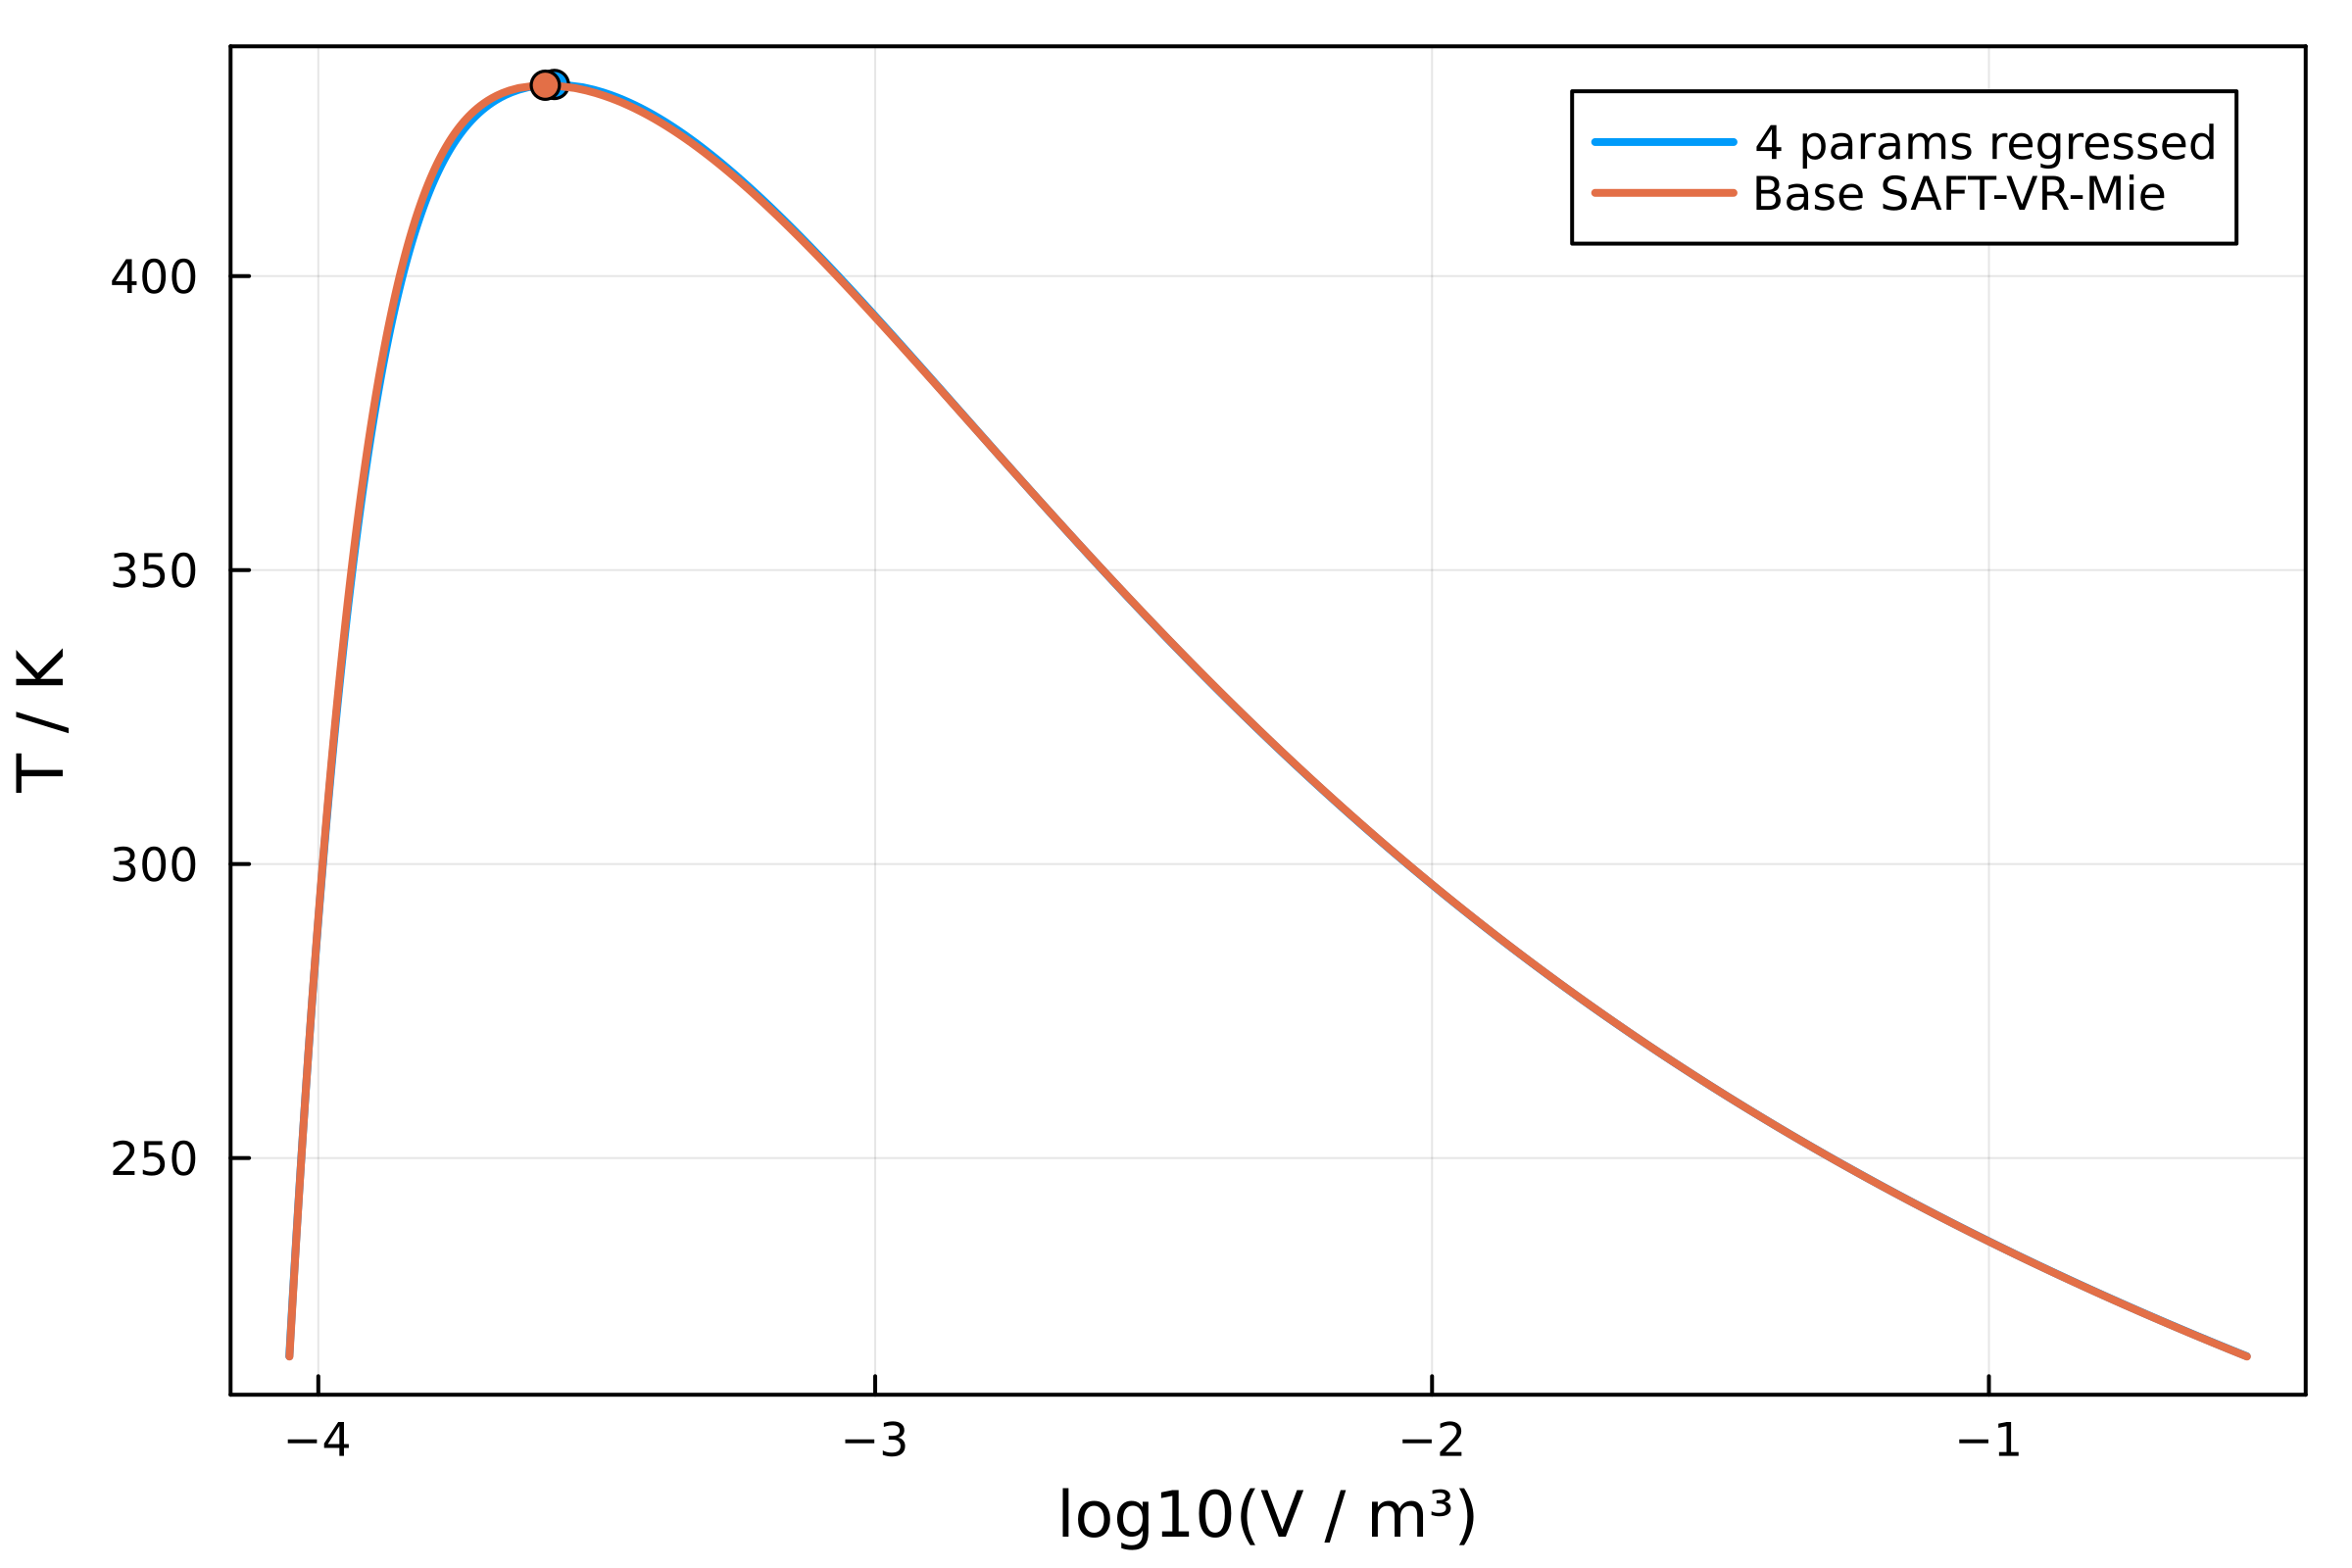

In [60]:
Mw = 58.12
λ_a = 6.0

plot(;box=:on, dpi=400, xlabel="log10(V / m³)", ylabel="T / K")
function f(model, c, label)
    # Create saturation envelope
    Tc, pc, Vc = crit_pure(model)
    T_range = range(0.5 * Tc, 0.9999 * Tc, 500)

    p_sat =  Float64[]
    Vl_sat = Float64[]
    Vv_sat = Float64[]
    for T in T_range
        (p, Vl, Vv) = saturation_pressure(model, T)
        push!(p_sat, p)
        push!(Vl_sat, Vl)
        push!(Vv_sat, Vv)
    end

    # plot!(T_range, p_sat, label="saturation pressure")
    plot!(log10.(Vl_sat), T_range, label=label, lw=2, color=c)
    plot!(log10.(Vv_sat), T_range, label="", lw=2, color=c)
    scatter!([log10(Vc)], [Tc], label="", color=c)
end

pred_model = make_model(vcat(Mw, params[1:2], [λ_a], params[3:4])...)
base_model = SAFTVRMie(["n-butane"])
f(pred_model, 1, "4 params regressed")
f(base_model, 2, "Base SAFT-VR-Mie")
#* Plot nominal parameters

In [49]:
df = CSV.read("./pcpsaft_params/SI_pcp-saft_parameters.csv", DataFrame, header=1)
filter!(row -> occursin("Alkane", row.family), df)
df = first(df, 1) #* Take only first molecule in dataframe
mol_data = zip(df.common_name, df.isomeric_smiles, df.molarweight)
saft_model = SAFTVRMie([first(mol_data)[1]])
saft_model.params.segment.values[1], saft_model.params.sigma.values[1]*1e10, saft_model.params.epsilon.values[1], saft_model.params.lambda_r.values[1]

(1.8514, 4.0887, 273.64, 13.65)